### Import required packages

In [ ]:
using IR
using StaticArrays
using DataFrames
using CairoMakie
using ColorSchemes

Define parameters of system and package them into a named tuple with abbreviated names

In [ ]:
player_execution_mistake_rate = 0.01
judge_execution_mistake_rate = 0.0
player_perception_mistake_rate = 0.0
judge_perception_mistake_rate = 0.0
proportion_incumbents_red = 0.9
utilities = SA[2, 2, 1, 1]

p = (;
    rem = player_execution_mistake_rate,
    bem = player_execution_mistake_rate,
    jem = judge_execution_mistake_rate,
    rpm = player_perception_mistake_rate,
    bpm = player_perception_mistake_rate,
    jpm = judge_perception_mistake_rate,
    pR = proportion_incumbents_red,
    utilities = utilities
)

Define a function to generate the dataframe we'll be working with for the rest of the script

In [ ]:
function get_agents(norm_i, rs_i, bs_i; p)
    norm = iNorm(norm_i)
    judge = Agent(norm, p.jem, p.jpm)
    red_strat = iStrategy(rs_i)
    red = Agent(red_strat, p.rem, p.rpm)
    blue_strat = iStrategy(bs_i)
    blue = Agent(blue_strat, p.bem, p.bpm)
    return judge, red, blue
end

function find_ESS(;p)
    norm_ints = 0:255
    strategy_ints = 0:15
    df = rename!(
        DataFrame(Iterators.product(norm_ints, strategy_ints, strategy_ints)),
        [:norm, :red_strat, :blue_strat],
    )
    df[!, :is_ess] = map(eachrow(df)) do row
        judge, red, blue = get_agents(row...; p)
        is_ESS(judge, red, blue, p.pR, p.utilities)
    end
    return df
end

In [ ]:
df = find_ESS(;p);

In [ ]:
# Uncomment cbar stuff for colors based on sum of number of cooperative bits
function generate_quadrant_df(_df; p)
    df = deepcopy(_df)
    
    info_df = DataFrame([:red_rep, :blue_rep, :red_payoff, :blue_payoff, :fairness, :cooperation] .=> Ref(Float64[]))
    quadrants = Int8[]
    foreach(eachrow(df)) do row
        n,r,b, _ = row
        judge, red, blue = get_agents(n,r,b; p)
        red_rep, blue_rep = stationary_incumbent_reputations(judge, red, blue, p.pR)
        red_payoff, blue_payoff = incumbent_payoffs(red, blue, red_rep, blue_rep, p.pR, p.utilities)
        prd = p_receives(red, blue, red_rep, p.pR)
        pbd = p_receives(blue, red, blue_rep, 1 - p.pR)
        fairness = prd > pbd ? pbd/prd : prd/pbd
        cooperation = (prd + pbd) / 2
        push!(info_df, (red_rep, blue_rep, red_payoff, blue_payoff, fairness, cooperation))
        push!(quadrants, (cooperation < 0.5) + 2(fairness < 0.5))
    end
    df = hcat(df, info_df, quadrants)
    rename!(df, :x1 => :quadrant)
    subset!(df, :is_ess)
    subset!(df, :red_strat => ByRow(!=(0)))
    unique!(df, [:red_payoff, :blue_payoff, :red_rep, :blue_rep])
    return df
end

In [ ]:
generate_quadrant_df(df; p);

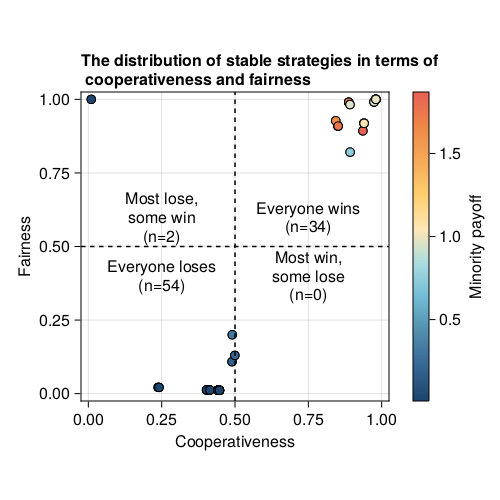

In [68]:

quadrant_df = generate_quadrant_df(df; p)
quadrant_size = map(0:3) do quadrant_i
    sdf = subset(quadrant_df, :quadrant => ByRow(==(quadrant_i)))
    size(sdf, 1)
end
ticks = 0:0.25:1
fig = Figure(; resolution=(500, 500))
ax = Axis(
    fig[1, 1];
    xlabel="Cooperativeness",
    ylabel="Fairness",
    xticks=ticks,
    yticks=ticks,
    title="The distribution of stable strategies in terms of\n cooperativeness and fairness",
    titlealign=:left,
    aspect=DataAspect(),
)
offset = 0.025
lims = (0 - offset, 1 + offset)
limits!(ax, lims, lims)
cmap = cgrad(:Hiroshige; rev=true)
sc = scatter!(
    ax,
    quadrant_df.cooperation,
    quadrant_df.fairness;
    colormap=cmap,
    color=quadrant_df.blue_payoff,
    strokewidth=1,
)
hlines!(ax, 0.5; color=:black, linestyle=:dash)
vlines!(ax, 0.5; color=:black, linestyle=:dash)
Colorbar(fig[1, 2], sc; label="Minority payoff")
quadrant_text = (
    "Everyone wins", "Most lose,\nsome win", "Most win,\nsome lose", "Everyone loses"
)
quadrant_labels = [text * "\n(n=$n)" for (text, n) in zip(quadrant_text, quadrant_size)]
x_offset = 0.25
x_offsets = (x_offset, -x_offset, x_offset, -x_offset)
y_offset = 0.1
y_offsets = (y_offset, y_offset, -y_offset, -y_offset)
for (quadrant_label, x_offset, y_offset) in zip(quadrant_labels, x_offsets, y_offsets)
    text!(
        ax,
        quadrant_label;
        position=(0.5 + x_offset, 0.5 + y_offset),
        word_wrap_with=2,
        align=(:center, :center),
    )
end
rowsize!(fig.layout, 1, Aspect(1, 1))
save("./figures/pnas/coop_fairness_payoff_scatter.pdf", fig)
fig

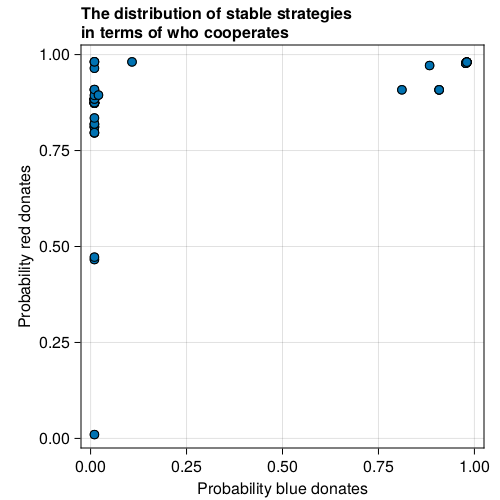

In [63]:

function generate_scatter_df(_df; p)
    df = deepcopy(_df)
    info_df = DataFrame([:red_rep, :blue_rep, :red_payoff, :blue_payoff, :red_receives, :red_donates, :blue_receives, :blue_donates] .=> Ref(Float64[]))
    quadrants = Int8[]
    foreach(eachrow(df)) do row
        n,r,b, _ = row
        judge, red, blue = get_agents(n,r,b; p)
        red_rep, blue_rep = stationary_incumbent_reputations(judge, red, blue, p.pR)
        red_payoff, blue_payoff = incumbent_payoffs(red, blue, red_rep, blue_rep, p.pR, p.utilities)
        prr = p_receives(red, blue, red_rep, p.pR)
        pbr = p_receives(blue, red, blue_rep, 1 - p.pR)
        prd = p_donates(red, red_rep, blue_rep, p.pR)
        pbd = p_donates(blue, blue_rep, red_rep, 1 - p.pR)
        
        push!(info_df, (red_rep, blue_rep, red_payoff, blue_payoff, prr, prd, pbr, pbd))
        push!(quadrants, (prd < 0.5) + 2(pbd < 0.5))
    end
    df = hcat(df, info_df, quadrants)
    rename!(df, :x1 => :quadrant)
    subset!(df, :is_ess)
    subset!(df, :red_strat => ByRow(!=(0)))
    unique!(df, [:red_payoff, :blue_payoff, :red_rep, :blue_rep])
    return df
end

scatter_df = generate_scatter_df(df; p)
quadrant_size = map(0:3) do quadrant_i
    sdf = subset(scatter_df, :quadrant => ByRow(==(quadrant_i)))
    size(sdf, 1)
end

ticks = 0:0.25:1
fig = Figure(; resolution=(500, 500))
ax = Axis(
    fig[1, 1];
    xlabel="Probability blue donates",
    ylabel="Probability red donates",
    xticks=ticks,
    yticks=ticks,
    title="The distribution of stable strategies\nin terms of who cooperates",
    titlealign=:left,
    aspect=DataAspect(),
)
offset = 0.025
lims = (0 - offset, 1 + offset)
limits!(ax, lims, lims)
# cmap = cgrad(:Hiroshige; rev=true)
sc = scatter!(
    ax,
    scatter_df.blue_donates,
    scatter_df.red_donates;
    # colormap=cmap,
    # color=quadrant_df.blue_payoff,
    strokewidth=1,
)
# hlines!(ax, 0.5; color=:black, linestyle=:dash)
# vlines!(ax, 0.5; color=:black, linestyle=:dash)
# Colorbar(fig[1, 2], sc; label="Minority payoff")
# quadrant_text = (
#     "Everyone wins", "Most lose,\nsome win", "Most win,\nsome lose", "Everyone loses"
# )
# quadrant_labels = [text * "\n(n=$n)" for (text, n) in zip(quadrant_text, quadrant_size)]
x_offset = 0.25
x_offsets = (x_offset, -x_offset, x_offset, -x_offset)
y_offset = 0.1
y_offsets = (y_offset, y_offset, -y_offset, -y_offset)
# for (quadrant_label, x_offset, y_offset) in zip(quadrant_labels, x_offsets, y_offsets)
#     text!(
#         ax,
#         quadrant_label;
#         position=(0.5 + x_offset, 0.5 + y_offset),
#         word_wrap_with=2,
#         align=(:center, :center),
#     )
# end
rowsize!(fig.layout, 1, Aspect(1, 1))
# save("./figures/pnas/coop_fairness_payoff_scatter.pdf", fig)
fig

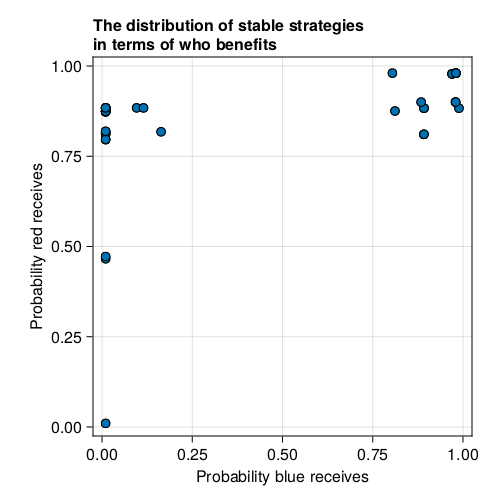

In [65]:
ticks = 0:0.25:1
fig = Figure(; resolution=(500, 500))
ax = Axis(
    fig[1, 1];
    xlabel="Probability blue receives",
    ylabel="Probability red receives",
    xticks=ticks,
    yticks=ticks,
    title="The distribution of stable strategies\nin terms of who benefits",
    titlealign=:left,
    aspect=DataAspect(),
)
offset = 0.025
lims = (0 - offset, 1 + offset)
limits!(ax, lims, lims)
cmap = cgrad(:Hiroshige; rev=true)
sc = scatter!(
    ax,
    scatter_df.blue_receives,
    scatter_df.red_receives;
    colormap=cmap,
    # color=quadrant_df.blue_payoff,
    strokewidth=1,
)
# hlines!(ax, 0.5; color=:black, linestyle=:dash)
# vlines!(ax, 0.5; color=:black, linestyle=:dash)
# Colorbar(fig[1, 2], sc; label="Minority payoff")
# quadrant_text = (
#     "Everyone wins", "Most lose,\nsome win", "Most win,\nsome lose", "Everyone loses"
# )
# quadrant_labels = [text * "\n(n=$n)" for (text, n) in zip(quadrant_text, quadrant_size)]
# x_offset = 0.25
# x_offsets = (x_offset, -x_offset, x_offset, -x_offset)
# y_offset = 0.1
# y_offsets = (y_offset, y_offset, -y_offset, -y_offset)
# for (quadrant_label, x_offset, y_offset) in zip(quadrant_labels, x_offsets, y_offsets)
#     text!(
#         ax,
#         quadrant_label;
#         position=(0.5 + x_offset, 0.5 + y_offset),
#         word_wrap_with=2,
#         align=(:center, :center),
#     )
# end
# rowsize!(fig.layout, 1, Aspect(1, 1))
# save("./figures/pnas/coop_fairness_payoff_scatter.pdf", fig)
fig

In [ ]:
scatter_df

In [69]:
subset(quadrant_df, :cooperation => ByRow(>=(0.5)))

Row,norm,red_strat,blue_strat,is_ess,red_rep,blue_rep,red_payoff,blue_payoff,fairness,cooperation,quadrant
,Int64,Int64,Int64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Int8
1,23,6,0,true,0.0188538,0.908854,0.786303,1.61322,0.92716,0.84349,0
2,159,6,0,true,0.0925,0.999167,0.712497,1.77253,0.909286,0.85084,0
3,7,7,0,true,0.0099108,0.900819,0.785259,1.774,0.9902,0.887629,0
4,135,7,0,true,0.01,0.901639,0.78518,1.774,0.990112,0.88759,0
5,143,7,0,true,0.0917431,0.990991,0.713083,1.774,0.909285,0.851541,0
6,144,9,0,true,0.9075,0.000833333,0.712497,1.77253,0.909286,0.85084,0
7,178,9,0,true,0.981146,0.0911462,0.786303,1.61322,0.92716,0.84349,0
8,208,13,0,true,0.908257,0.00900901,0.713083,1.774,0.909285,0.851541,0
9,210,13,0,true,0.99,0.0983607,0.78518,1.774,0.990112,0.88759,0
